Dataset: NBoption.csv.
Apply selective learning for this dataset and compare its results with original machine learning methods:
- Learning machines: k-NN, SVM;
- Training-test partition: 80% training data and 20% test data; Train-train and train-test par- tition: 80%: 20%;
- Bad guys: the samples whose values error = | Volatility - predictedVolatility| are at the bottom 10% of all train-test samples: The number of nearest neighbors: k = 10;
Note: you should try selective learning both two stages: training clean and test clean

In [3]:
import pandas as pd
from sklearn.model_selection import train_test_split
import numpy as np
from matplotlib.colors import ListedColormap
from sklearn.neighbors import KNeighborsRegressor 
import matplotlib.pyplot as plt

Intial K-nn

In [9]:
option = pd.read_csv('NBOption.csv')
option.head()

training_data, testing_data = train_test_split(option, test_size = 0.30, random_state=42)
train_train, train_test = train_test_split(training_data, test_size = 0.30, random_state=42)

train_data = train_train.iloc[:,4:5]
train_lab = train_train['Volatility']
test_data = train_test.iloc[:,4:5]
test_lab = train_test['Volatility']
err = lambda x,y: (x-y)**2

#knn distance where k=10
knn = KNeighborsRegressor(n_neighbors=10, weights='distance')
knn.fit(train_data, train_lab)
predicted = knn.predict(test_data)
#T = np.linspace(0, 250, 2994)[:, np.newaxis]
error =  err(test_lab, predicted)
mse = error.mean()
print(mse)
df = train_test.assign(pred_Vola = predicted, error = error)
df_sort = df.sort_values(by=['StockPrice'])

0.016019250776567604


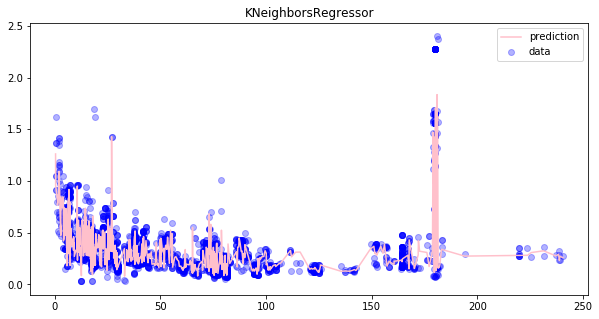

In [15]:
plt.figure(1, figsize=(10, 5))
plt.scatter(df_sort['StockPrice'], df_sort['Volatility'], c='b', label='data', alpha = 0.3)
plt.plot(df_sort['StockPrice'], df_sort['pred_Vola'], c= 'pink', label= 'prediction')
plt.axis('tight')
plt.legend()
plt.title("KNeighborsRegressor")
plt.show()

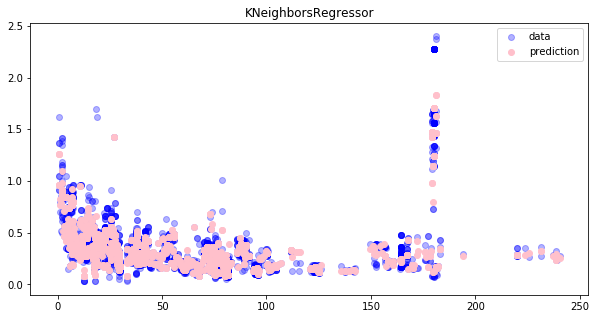

In [16]:
plt.figure(1, figsize=(10, 5))
plt.scatter(df_sort['StockPrice'], df_sort['Volatility'], c='b', label='data', alpha = 0.3)
plt.scatter(df_sort['StockPrice'], df_sort['pred_Vola'], c= 'pink', label= 'prediction')
plt.axis('tight')
plt.legend()
plt.title("KNeighborsRegressor")
plt.show()

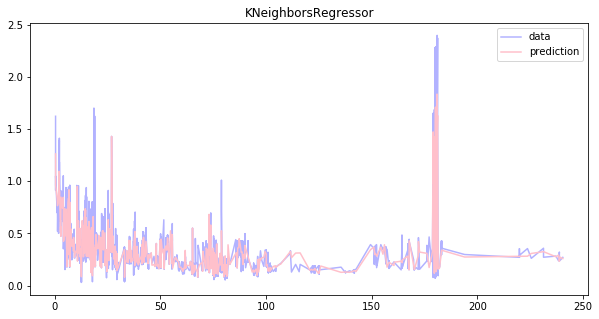

In [17]:
plt.figure(1, figsize=(10, 5))
plt.plot(df_sort['StockPrice'], df_sort['Volatility'], c='b', label='data', alpha = 0.3)
plt.plot(df_sort['StockPrice'], df_sort['pred_Vola'], c= 'pink', label= 'prediction')
plt.axis('tight')
plt.legend()
plt.title("KNeighborsRegressor")
plt.show()

Eliminate bottom 10% to drop from the test-train set to arrive ar "clean_train_test"

In [18]:
df_sort2 = df.sort_values(by=['error'])
n = int(len(df_sort2)*0.1)
bot_10 = df_sort2.iloc[-n:]
print("\nBottom 10% of all testing samples are:" + "\n")
print(bot_10)
clean_train_test = df_sort2.drop(df_sort2.tail(n).index)
clean_train_test = clean_train_test.drop(['pred_Vola', 'error'], axis = 1)


Bottom 10% of all testing samples are:

      DataType     Ask     Bid  LastPrice  StockPrice  Strike  Volatility  \
11853     call    0.20    0.00       0.11        7.20    10.5    0.962541   
11855     call    0.31    0.00       0.12        7.20    12.5    0.962541   
10148     call    0.02    0.00       0.01        4.89     6.5    0.345530   
10149     call    0.01    0.00       0.01        4.89     7.0    0.345530   
3044       put    0.01    0.00       0.01        4.89     2.0    0.345530   
3046       put    0.02    0.00       0.01        4.89     3.5    0.345530   
10142     call    4.10    3.70       3.45        4.89     1.0    0.345530   
10152     call    0.01    0.00       0.02        4.89     9.0    0.345530   
685        put    1.55    1.40       1.40      100.95    75.0    0.320151   
9498      call    2.64    2.59       2.62       11.59     9.0    0.307623   
1349       put    0.13    0.07       0.17      172.68   135.0    0.156116   
5463       put    0.10    0.00     

In order to clean “train train” and “testing data”, we have to first find the neighbors of those “trouble makers”. We use Euclidean distance to find the neighbors. 
The functions below will return the index of the neighbors.

In [26]:
import math
def euclidean(x, y, length):
    distance = 0
    for i in range(length):
        distance += pow((x[i]-y[i]), 2)
    return math.sqrt(distance)

import operator
def getNeighbors(bot, cleandata, k, length):
    tot = []
    for j in range(len(bot)):
        distances = []
        for i in range (len(cleandata)):
            dist = euclidean(cleandata[i], bot[j], length)
            distances.append((i, dist))
        distances.sort(key = operator.itemgetter(1))
        neighbors = []
        for x in range (k):
            neighbors.append(distances[x][0])
        tot.append(neighbors)
    return tot

Apply these functions to get the neighbors in train_train

In [37]:
cleandata = train_train[['StockPrice', 'Volatility']].as_matrix()

bot = bot_10[['StockPrice', 'Volatility']].as_matrix()
k = 5 
length = 1
ne_list = getNeighbors(bot, cleandata, k, length)


In an effort to avoid duplicated datas, we chose unique index values to ensure. 

In [42]:
print(ne_list[100])
print(ne_list[150])

[212, 398, 620, 673, 910]
[21, 27, 74, 76, 99]


Clean “train train” by droppin “bad neighbors”. 
There are 510 rows dropped, which is roughly 7%.

In [50]:
from collections import Iterable

def flatten(lis):
    for item in lis:
        if isinstance(item, Iterable) and not isinstance (item, str):
            for x in flatten(item):
                yield x
        else:
            yield item

                
bad_rowno = list(set(list(flatten(ne_list))))
clean_train_train = train_train.drop(train_train.index[bad_rowno])

When we clean the “testing data” we dropped 302 rows, which is approximately 7 percents as well.(Due to less data length, we pick the nearest 3 neighbors compared to 5 previously.)

In [53]:
cleandata = testing_data[['StockPrice', 'Volatility']].as_matrix()
k=3
ne_list = getNeighbors(bot, cleandata, k, length)
bad_rowno = list(set(list(flatten(ne_list))))
clean_testing_data = testing_data.drop(testing_data.index[bad_rowno])

bad_rowno[:10]

[1221, 2562, 2, 4, 5, 1031, 13, 14, 2064, 17]

We have cleaned all the data, the last step is to put all the after-cleaned data together and re-do our kNN regression

In [69]:
import compute_measure #local module (provided in github)
train = clean_train_train.append(clean_train_test)
test = clean_testing_data

traindata = train.iloc[:,4:5]
trainlab = train['Volatility']
testdata = test.iloc[:,4:5]
testlab = test['Volatility']

knn = KNeighborsRegressor(n_neighbors=10, weights ='distance')
knn.fit(traindata, trainlab)
predicted = knn.predict(testdata)
error = err(testlab, predicted)
mse1 = error.mean()
print(mse1)

df = test.assign(pred_Vola = predicted, error = error)
df_sort = df.sort_values(by=['StockPrice'])
len(test)
len(testing_data)

ans = (predicted, testlab)
print('\n check the following classification measure: accuracy, sen, spec, ppr, npr \n')
print('{}'.format(ans))

ModuleNotFoundError: No module named 'compute_measure'